**Applied Machine Learning - Homework 3**

Amaury Sudrie (UNI: AS5961)
Maxime Tchibozo (UNI: MT3390)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("drive/My Drive/AML/")

In [0]:
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
df = pd.read_csv('vehicles.csv')

In [0]:
df.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,vin,drive,size,type,paint_color,image_url,description,county,state,lat,long
0,7034441763,https://saltlakecity.craigslist.org/cto/d/salt...,salt lake city,https://saltlakecity.craigslist.org,17899,2012.0,volkswagen,golf r,excellent,4 cylinders,gas,63500.0,clean,manual,WVWPF7AJ6CW316713,4wd,compact,hatchback,black,https://images.craigslist.org/00G0G_fTLDWM5Xyv...,PRICE REDUCED! -Garage kept -Low Miles (63K)...,NaN,ut,40.7372,-111.858
1,7034440610,https://saltlakecity.craigslist.org/ctd/d/sand...,salt lake city,https://saltlakecity.craigslist.org,0,2016.0,ford,f-150,excellent,NaN,gas,10.0,clean,automatic,1FTMF1EP3GKF13544,4wd,NaN,NaN,NaN,https://images.craigslist.org/00v0v_7Cu0buIofU...,Drive it home today. Call (Or Text) us now !!C...,NaN,ut,40.5881,-111.884
2,7034440588,https://saltlakecity.craigslist.org/ctd/d/sand...,salt lake city,https://saltlakecity.craigslist.org,46463,2015.0,gmc,sierra 1500,excellent,NaN,gas,7554.0,clean,automatic,3GTU2WEC6FG228025,4wd,NaN,NaN,white,https://images.craigslist.org/01515_lPvJ9bfbdY...,Drive it home today. Call (Or Text) us now !!C...,NaN,ut,40.5881,-111.884
3,7034440546,https://saltlakecity.craigslist.org/ctd/d/sand...,salt lake city,https://saltlakecity.craigslist.org,0,2016.0,ford,f-150,excellent,NaN,gas,10.0,clean,automatic,1FTEX1EF6GKD25447,4wd,NaN,NaN,NaN,https://images.craigslist.org/00T0T_6Rjfp3NS4O...,Drive it home today. Call (Or Text) us now !!C...,NaN,ut,40.5881,-111.884
4,7034406932,https://saltlakecity.craigslist.org/ctd/d/evan...,salt lake city,https://saltlakecity.craigslist.org,49999,2018.0,ford,f-450,NaN,NaN,diesel,70150.0,clean,automatic,1FT8W4DT8GEA90427,4wd,NaN,pickup,white,https://images.craigslist.org/00W0W_8yIUwRBXXd...,2018 Ford F-350 F350 F 350 SD Lariat Crew Cab ...,NaN,ut,40.3744,-104.694


In [0]:
nrows = len(df)
print("number of rows:", nrows)

number of rows: 509577


# **Task 1 : Identify Features**

Assemble a dataset consisting of features and target (for example in a dataframe or in two  arrays X and y). What features are relevant for the prediction task?  Are there any features that should be excluded because they leak the target information?  Show visualizations or statistics to support your selection.  You are not required to use the description column, but you can try to come up with relevant  features using it. Please don’t use bag-of-word approaches for now as we’ll discuss these later  in the class. 

### **NA values**
First we can have a look at the NAs repartition in the dataframe.

In [0]:
df.isnull().sum(axis = 0)

id                   0
url                  0
region               0
region_url           0
price                0
year              1527
manufacturer     22764
model             7989
condition       231934
cylinders       199683
fuel              3985
odometer         92324
title_status      3062
transmission      3719
vin             207425
drive           144143
size            342003
type            141531
paint_color     164706
image_url           14
description         16
county          509577
state                0
lat              10292
long             10292
dtype: int64

The **county** column contains only NA, thus we can immediately drop it.

In [0]:
df = df.drop(columns="county")

### **Columns that leak informations**

Several columns repeat information already present in other columns. This is the case for **description** which sometimes repeats the **price**, and  **region_url** which repeat the **region** name.

In [0]:
df['description'].iloc[4][129:136]

'$49,999'

In [0]:
df['region_url'].iloc[4][8:20]

'saltlakecity'

In [0]:
df = df.drop(columns=["description", "region_url"])

### **Columns which contains too much unique values**

In [0]:
for key in df.keys():
  print(key, len(df[key].unique()))

id 509577
url 509577
region 403
price 17854
year 115
manufacturer 44
model 35853
condition 7
cylinders 9
fuel 6
odometer 119874
title_status 7
transmission 4
vin 180146
drive 4
size 5
type 14
paint_color 13
image_url 349469
state 51
lat 51489
long 51468


We can observe that **id**, **url** and **image_url** contains more than 75% of unique values. This is not really interesting for analysis purposes. Let's drop them.

In [0]:
df = df.drop(columns=["id", "url", "image_url"])

### **Data cleanining**

Text(0.5, 1.0, 'Histogram of Price for the first 1000 rows')

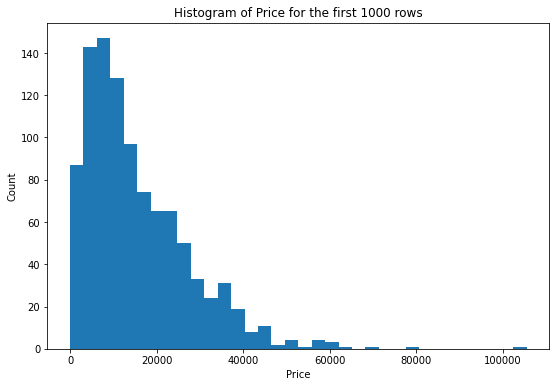

In [0]:
plt.figure(figsize=(9,6))
plt.hist(df['price'].iloc[0:1000],bins='auto')
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Histogram of Price for the first 1000 rows')

In [0]:
max(df["price"])

3600028900

Here we can see on the first 1000 rows that the range of prices is mainly between $0\$ $ and $ 100,000\$ $. Nonetheless a good propotion of the price are equal to $ 0\$ $ and prices goes to more than 3.5 millions of dollars. These value seem too high. Thus for analyzing purpose we will keep only strictly positive prices and prices lower than $ 500,000\$ $.

In [0]:
df = df[df.price > 0]
df = df[df.price <= 500000]
df.reset_index(drop=True, inplace=True)
nrows = len(df)
print("new number of rows:", nrows)

new number of rows: 465915


Now the final step of cleaning is the VIN which is a unique identification number for each vehicle. Thus we will focus on non-NA VIN and correctly encoded ones.

In [0]:
def is_valid_vin(string):
  string = str(string) #Handles NaN values
  string = re.sub(r'[^\w\s]','',string) #Handles punctuation
  string = string.replace(' ','') #Handles spaces
  if len(string)==17:
    return True
  return False

df['valid_vin'] = df['vin'].apply(lambda x : is_valid_vin(x))
df = df[df.valid_vin == True].drop(['valid_vin'],axis=1)
df['vin'].value_counts().head()

WDC0G4JB4HF164180    114
WDDZF4JB6KA584632     88
3AKJGLD52GSGU5247     51
1XPBDP9X5HD363709     44
1G1ZC5ST7GF261886     34
Name: vin, dtype: int64

As we can see, the same car appears several times in the dataset (for example if it was listed in several different states), thus we will remove the duplicates. Once duplicates are removed, we drop this column as it does not give new information.

In [0]:
df = df.drop_duplicates(subset='vin')
df = df.drop(['vin'],axis=1)
df.reset_index(drop=True, inplace=True)
nrows = len(df)
print("new number of rows:", nrows)

new number of rows: 158801


In [0]:
df.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,lat,long
0,salt lake city,17899,2012.0,volkswagen,golf r,excellent,4 cylinders,gas,63500.0,clean,manual,4wd,compact,hatchback,black,ut,40.7372,-111.858
1,salt lake city,46463,2015.0,gmc,sierra 1500,excellent,NaN,gas,7554.0,clean,automatic,4wd,NaN,NaN,white,ut,40.5881,-111.884
2,salt lake city,49999,2018.0,ford,f-450,NaN,NaN,diesel,70150.0,clean,automatic,4wd,NaN,pickup,white,ut,40.3744,-104.694
3,salt lake city,13999,2009.0,ram,NaN,NaN,NaN,gas,120057.0,clean,automatic,4wd,NaN,pickup,silver,ut,40.3744,-104.694
4,salt lake city,34500,2017.0,ford,f-350,NaN,NaN,diesel,95484.0,clean,automatic,4wd,NaN,pickup,white,ut,40.3744,-104.694


In [0]:
X,y = df.drop(['price'],axis=1),df['price']

# **Task 2 Preprocessing and Baseline Model**
Create a simple minimum viable model by doing an initial selection of features, doing appropriate preprocessing and cross-validating a linear model. Feel  free to exclude features or do simplified preprocessing for this task. As mentioned before, you don’t need to validate the model on the whole dataset.

In [0]:
!pip install category_encoders

     |████████████████████████████████| 102kB 2.3MB/s 


In [0]:
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV

from category_encoders.target_encoder import TargetEncoder

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [0]:
cat = ['model']
cont = ['year', 'odometer', 'lat', 'long']

X2 = X_train[cat + cont]
X2[cat] = X2[cat].fillna('missing').copy()

Cont_Imputer = SimpleImputer(strategy='median')
X2[cont] = Cont_Imputer.fit_transform(X2[cont]).copy()

In [0]:
preprocess = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), cat)
)                                     

model_LR = make_pipeline(preprocess, LinearRegression())

scores = cross_val_score(model_LR, X2, y_train)
print("Score Linear Regression", np.mean(scores))


Score Linear Regression 0.3406113316764025


A basic Linear Regression model on **model, year, odometer, lat, long** yields a score of 0.34.

# **Task 3 : Feature Engineering**
Create derived features and perform more in-depth preprocessing and data cleaning. Does this  improve your model? In particular, think about how to encode categorical variables and  whether adding interactions (for example using PolynomialFeatures or manually) might help. 

First we will we will select which feature to One Hot Encode and the ones and the one to Target Encode. We will choose the latter one when there is more than 50 unique possible values.

In [0]:
for key in df.keys():
  print(key, len(df[key].unique()))

region 399
price 14588
year 70
manufacturer 44
model 19559
condition 7
cylinders 9
fuel 6
odometer 95032
title_status 7
transmission 4
drive 4
size 5
type 14
paint_color 13
state 51
lat 21702
long 21161


Among these categories, we wont consider the ones with more than 30\% of missing values. Thus, in this part, we discard **condition**, **cylinders** and **size**.

In [0]:
percent_missing = df.isnull().sum() * 100 / nrows
percent_missing.rename(columns={0:'feature',1:'percentage'})

region           0.000000
price            0.000000
year             0.409947
manufacturer     3.071139
model            0.673170
condition       43.599222
cylinders       37.196239
fuel             1.005031
odometer         3.405520
title_status     0.936392
transmission     1.044704
drive           19.103784
size            66.777917
type            14.518800
paint_color     21.539537
state            0.000000
lat              1.522660
long             1.522660
dtype: float64

In [0]:
cont_tot = ['year', 'odometer', 'lat', 'long']
cat_TE_tot = ['model', 'region']
cat_OHE_tot = ['manufacturer', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'state']

cont = ['year', 'odometer', 'lat', 'long']
cat_TE = ['model', 'region']
cat_OHE = ['manufacturer', 'fuel', 'title_status', 'transmission', 'drive', 'type', 'paint_color', 'state']

X3 = X_train[cont + cat_OHE + cat_TE]
X3[cat_OHE + cat_TE] = X3[cat_OHE + cat_TE].fillna('missing')
Cont_Imputer = SimpleImputer(strategy='median')
X3[cont] = Cont_Imputer.fit_transform(X3[cont])

X3_test = X_test[cont + cat_OHE + cat_TE]
X3_test[cat_OHE + cat_TE] = X3_test[cat_OHE + cat_TE].fillna('missing')
X3_test[cont] = Cont_Imputer.transform(X3_test[cont])

Using the information above we target encode the **models** and the **regions** and OneHotEncode the rest. We also add a scaler to the regression model.

In [0]:
preprocess = make_column_transformer(
    (TargetEncoder(), cat_TE),
    (OneHotEncoder(handle_unknown='ignore'), cat_OHE),
    (StandardScaler(), cont)
)

model_LR = make_pipeline(preprocess, LinearRegression())

scores = cross_val_score(model_LR, X3, y_train)
print("Score Linear Regression", np.mean(scores))

Score Linear Regression 0.5513346273363797


This model improve from a score of 0.34 to 0.55. Let's see if we can improve it using Polynomial Features. We perform a quick grid search to see if we take degree higher than 2 or not.

In [0]:
X3_sub, _, y_sub, _ = train_test_split(X3, y_train, train_size=0.25)

preprocess = make_column_transformer(
    (TargetEncoder(), cat_TE),
    (OneHotEncoder(handle_unknown='ignore'), cat_OHE),
    (StandardScaler(), cont)
)

model_LR = make_pipeline(preprocess,  PolynomialFeatures(), LinearRegression())

param_grid_LR = {'polynomialfeatures__degree': [1, 2, 3]}  

grid_LR = GridSearchCV(model_LR, param_grid_LR, cv=5, return_train_score=True)
grid_LR.fit(X3_sub, y_sub)
print("Best mean cross-validation score for LR: {:.3f}".format(grid_LR.best_score_))
print("Best parameters: {}".format(grid_LR.best_params_))

Best mean cross-validation score for LR: 0.503
Best parameters: {'polynomialfeatures__degree': 2}


Thus we take **degree = 2**

In [0]:
preprocess = make_column_transformer(
    (TargetEncoder(), cat_TE),
    (OneHotEncoder(handle_unknown='ignore'), cat_OHE),
    (StandardScaler(), cont)
)                                     

model_LR = make_pipeline(preprocess, PolynomialFeatures(degree=2), LinearRegression())

scores = cross_val_score(model_LR, X3, y_train)
model_LR.fit(X3, y_train)
print("Score Linear Regression", np.mean(scores))

Score Linear Regression 0.5848638879400891


In [0]:
print("Score on test", model_LR.score(X3_test,y_test))

Score on test 0.6080754286863181


Polynomial Features increased the result from 0.55 to 0.58 on the training set and this new model yields a score of 0.6 on the test set.

# **Task 4 Any model**

Use any regression model we discussed (trees, forests, gradient boosting, SVM) to improve  your result. You can (and probably should) change your preprocessing and feature engineering  to be suitable for the model. You are not required to try all of these models. Tune parameters  as appropriate.  

In [0]:
from sklearn.ensemble import GradientBoostingRegressor

In [0]:
X4 = X_train[cont_tot + cat_OHE_tot + cat_TE_tot]
X4[cat_OHE_tot + cat_TE_tot] = X4[cat_OHE_tot + cat_TE_tot].fillna('missing')
Cont_Imputer = SimpleImputer(strategy='median')
X4[cont_tot] = Cont_Imputer.fit_transform(X4[cont_tot])

X4_test = X_test[cont_tot + cat_OHE_tot + cat_TE_tot]
X4_test[cat_OHE_tot + cat_TE_tot] = X4_test[cat_OHE_tot + cat_TE_tot].fillna('missing')
X4_test[cont_tot] = Cont_Imputer.transform(X4_test[cont_tot])

We will first try a Gradient Boosting model and start with a grid search on the **learning rate** and the trees **max depth** to find the best model.

In [0]:
X4_sub, _, y_sub, _ = train_test_split(X4,y_train, train_size=0.25)

preprocess = make_column_transformer(
    (TargetEncoder(), cat_TE_tot),
    (OneHotEncoder(handle_unknown='ignore'), cat_OHE_tot),
    (StandardScaler(), cont_tot)
)

model_GB = make_pipeline(preprocess, GradientBoostingRegressor())

param_grid_GB = {'gradientboostingregressor__learning_rate': [0.3, 0.4, 0.5],
                 'gradientboostingregressor__max_depth': [4, 5, 6, 7]}  

grid_GB = GridSearchCV(model_GB, param_grid_GB, cv=5, return_train_score=True)
grid_GB.fit(X4_sub, y_sub)
print("Best mean cross-validation score for GB: {:.3f}".format(grid_GB.best_score_))
print("Best parameters: {}".format(grid_GB.best_params_))


Best mean cross-validation score for GB: 0.698
Best parameters: {'gradientboostingregressor__learning_rate': 0.4, 'gradientboostingregressor__max_depth': 6}


Let us now apply the coefficient found above to whole train dataset

In [0]:
preprocess = make_column_transformer(
    (TargetEncoder(), cat_TE_tot),
    (OneHotEncoder(handle_unknown='ignore'), cat_OHE_tot),
    (StandardScaler(), cont_tot)
)                                     

model_GB = make_pipeline(preprocess, GradientBoostingRegressor(max_depth=6, learning_rate=0.4))

scores = cross_val_score(model_GB, X4, y_train)
model_GB.fit(X4, y_train)
print("Score GB", np.mean(scores))

Score GB 0.740312314809184


The Gradient Boosting performs well with a score of 0.74 which is very much better than the Linear Regression. Let us see if XGBoost can perform even better.

In [0]:
import xgboost as xgb
from xgboost import XGBRegressor, plot_tree

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

First we will do a grid search on XGBoost parameters

In [0]:
X4_sub, _, y_sub, _ = train_test_split(X4,y_train, train_size=0.2)

preprocess = make_column_transformer(
    (TargetEncoder(), cat_TE_tot),
    (OneHotEncoder(handle_unknown='ignore'), cat_OHE_tot),
    (StandardScaler(), cont_tot)
)

model_GB = make_pipeline(preprocess, XGBRegressor(silent=True))

param_grid_GB = {'xgbregressor__learning_rate': [0.3, 0.4, 0.5],
                 'xgbregressor__max_depth': [6, 7, 8, 9]}

grid_GB = GridSearchCV(model_GB, param_grid_GB, cv=5, return_train_score=True)
grid_GB.fit(X4_sub, y_sub)
print("Best mean cross-validation score for XGB: {:.3f}".format(grid_GB.best_score_))
print("Best parameters: {}".format(grid_GB.best_params_))


Best mean cross-validation score for XGB: 0.733
Best parameters: {'xgbregressor__learning_rate': 0.3, 'xgbregressor__max_depth': 8}


The grid search suggests to take a **max_depth** equal to 8 with a **learning rate** equal to 0.3

In [0]:
preprocess = make_column_transformer(
    (TargetEncoder(), cat_TE_tot),
    (OneHotEncoder(handle_unknown='ignore'), cat_OHE_tot),
    (StandardScaler(), cont_tot)
)

model_XGB = make_pipeline(preprocess, XGBRegressor(n_estimators=200, max_depth=8, learning_rate=0.3, silent=True))

scores = cross_val_score(model_XGB, X4, y_train)
print("Score XGB", np.mean(scores))

Score XGB 0.776259745354054


In [0]:
model_XGB.fit(X4, y_train)
print("Score on test", model_XGB.score(X4_test,y_test))

Score on test 0.7908734681614


In conclusion, XGBoost yields our best model, with a score of almost 0.78 on the training dataset and 0.79 on the test dataset.

# **Task 5 Feature Selections**
Identify features that are important for your best model. Which features are most influential, and which features could be removed without decrease in performance? Does removing irrelevant features make your model better? (This will be discussed in the lecture on 03/04).


We can first have a quick look at the continuous features using f_regression. We can see that both **lat** and **long** have small f-score thus these features will not be very interesting for analysis purposes.

In [0]:
from sklearn.feature_selection import f_regression

f_values, p_values = f_regression(X4[cont], y_train)
f_values

array([35829.0465505 , 12640.12175868,   224.22068378,  2418.9135207 ])

Let us now have a look on the permutation importance to learn more information on how important each feature is. Here we will focus on each feature globally, i.e. before its preprocessing. Specifically, we aim to get macro-information on categorical features before digging in with feature importance.

In [0]:
OHE_name = model_XGB.named_steps['columntransformer'].transformers_[1][1].categories_

XGB_labels = ['year', 'odometer', 'lat', 'long']
for i in range(len(cat_OHE_tot)):
  XGB_labels += [ cat_OHE_tot[i] + '_' + OHE_name[i][k] for k in range(len(OHE_name[i])) ]

XGB_labels += cat_TE_tot

In [0]:
perm_imp = permutation_importance(model_XGB, X4_test, y_test)['importances_mean']
cols = X4.columns.to_list()
imp = []
for i in range(len(cols)):
  imp.append((cols[i], perm_imp[i]))

imp.sort(key = lambda x : -x[1])
imp

[('year', 0.4921699022299695),
 ('model', 0.272153886687179),
 ('odometer', 0.21400045790094765),
 ('manufacturer', 0.09259029621860804),
 ('cylinders', 0.07352823684351688),
 ('fuel', 0.05977920538115529),
 ('drive', 0.04658700986565201),
 ('long', 0.04234814834582101),
 ('lat', 0.03921575890536137),
 ('state', 0.03608611500509418),
 ('type', 0.03233614579703674),
 ('condition', 0.01531946131605264),
 ('region', 0.013479645663455098),
 ('title_status', 0.009892037544221566),
 ('transmission', 0.0033034528513965046),
 ('size', 0.0027006664007149794),
 ('paint_color', 0.0019008295508678775)]

From the permutation importance process we can see that **year**, **model** and **odometer** are the most important features.

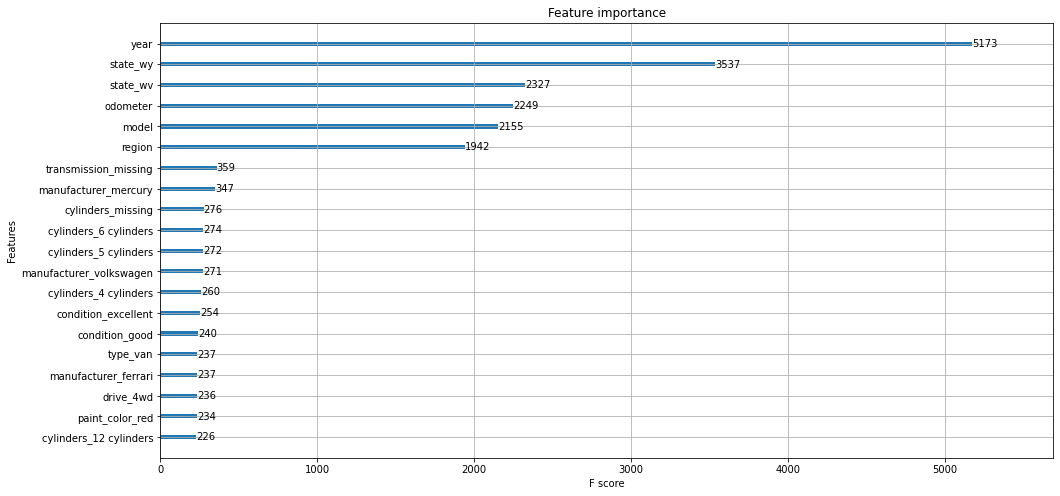

In [0]:
fig, ax = plt.subplots(figsize=(16,8))
model_XGB.named_steps["xgbregressor"].get_booster().feature_names = XGB_labels
xgb.plot_importance(model_XGB.named_steps["xgbregressor"], max_num_features=20, importance_type ='weight', ax=ax)

From the Feature Importance graph we can see that **year**, **state**, **odometer**, **model** and **region** have a high f-score thus these features could be considered as important.

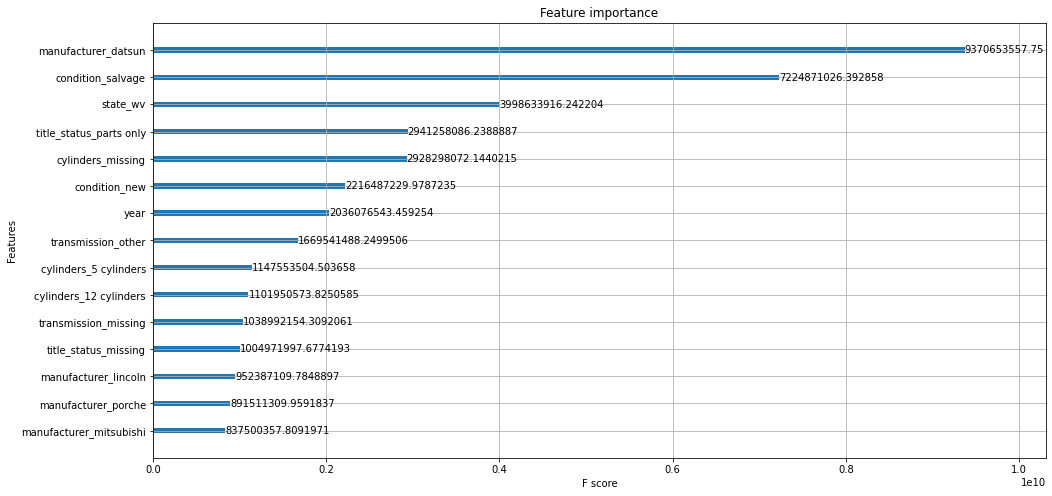

In [0]:
fig, ax = plt.subplots(figsize=(16,8))
model_XGB.named_steps["xgbregressor"].get_booster().feature_names = XGB_labels
xgb.plot_importance(model_XGB.named_steps["xgbregressor"], max_num_features=15, importance_type ='gain', ax=ax)

From the Split Gain graph we can see that **manufacturer**, **condition**, **state** and **cylinder** could add good information while splitting the tree.

Let us see what happens to our model while reducing the number of feature to what we mentioned above.

In [0]:
cont5 = ['year', 'odometer']
cat_TE5 = ['model', 'region']
cat_OHE5 = ['manufacturer', 'condition', 'cylinders', 'state']


X5 = X_train[cont5 + cat_OHE5 + cat_TE5]
X5[cat_OHE5 + cat_TE5] = X5[cat_OHE5 + cat_TE5].fillna('missing')
Cont_Imputer = SimpleImputer(strategy='median')
X5[cont5] = Cont_Imputer.fit_transform(X5[cont5])

X5_test = X_test[cont5 + cat_OHE5 + cat_TE5]
X5_test[cat_OHE5 + cat_TE5] = X5_test[cat_OHE5 + cat_TE5].fillna('missing')
X5_test[cont5] = Cont_Imputer.transform(X5_test[cont5])

In [0]:
preprocess = make_column_transformer(
    (TargetEncoder(), cat_TE5),
    (OneHotEncoder(handle_unknown='ignore'), cat_OHE5),
    (StandardScaler(), cont5)
)                        

model_XGB5 = make_pipeline(preprocess, XGBRegressor(n_estimators=200, max_depth=8, learning_rate=0.3, silent=True))

scores = cross_val_score(model_XGB5, X5, y_train)
model_XGB5.fit(X5, y_train)
print("Score XGB", np.mean(scores))
print("Score on test", model_XGB5.score(X5_test,y_test))

Score XGB 0.711926487199909
Score on test 0.7329463664564797


Finally, keeping all features gave a better performance. Nonetheless we can see that we decreased from 0.77 to 0.71 by dividing the number of feature by 2. In other words the features we kept are the one which are essential.

Let us see how the SelectFromModel perform compared to what we have done.

In [0]:
from sklearn.feature_selection import SelectFromModel

In [0]:
preprocess = make_column_transformer(
    (TargetEncoder(), cat_TE_tot),
    (OneHotEncoder(handle_unknown='ignore'), cat_OHE_tot),
    (StandardScaler(), cont_tot)
)

select_XGB = make_pipeline(
    preprocess,
    SelectFromModel(XGBRegressor(n_estimators=200, max_depth=8, learning_rate=0.3, silent=True)),
    XGBRegressor(n_estimators=200, max_depth=8, learning_rate=0.3, silent=True)
)

scores = cross_val_score(select_XGB, X4, y_train)
print("Score XGB", np.mean(scores))

Score XGB 0.7280759084285066


The selector is slightly better. In other words, the work we have done manually is as good as the SelectFromModel.

# **Task 6 An explainable model**
Can you create an “explainable” model that is nearly as good as your best model? An explainable model should be small enough to be easily inspected - say a linear model with few enough coefficients that you can reasonably look at all of them, or a tree with a small number of leaves etc.

In [0]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

In [0]:
cont6 = ['year', 'odometer']
cat6 = ['model', 'state', 'cylinders','manufacturer']

X6 = X_train[cont6 + cat6]
X6[cat6] = X6[cat6].fillna('missing')

Cont_Imputer = SimpleImputer(strategy='median')
X6[cont6] = Cont_Imputer.fit_transform(X6[cont6])

In [0]:
preprocess = make_column_transformer(
    (TargetEncoder(), cat6),
    (StandardScaler(), cont6)
)

model_simple = make_pipeline(preprocess,
                             PolynomialFeatures(degree=2,interaction_only=True),
                             DecisionTreeRegressor(max_leaf_nodes=20, max_depth=4, criterion="mse")
                             )

scores = cross_val_score(model_simple, X6, y_train)
model_simple.fit(X6, y_train)
print("Score simple model", np.mean(scores))

Score simple model 0.506415187579637


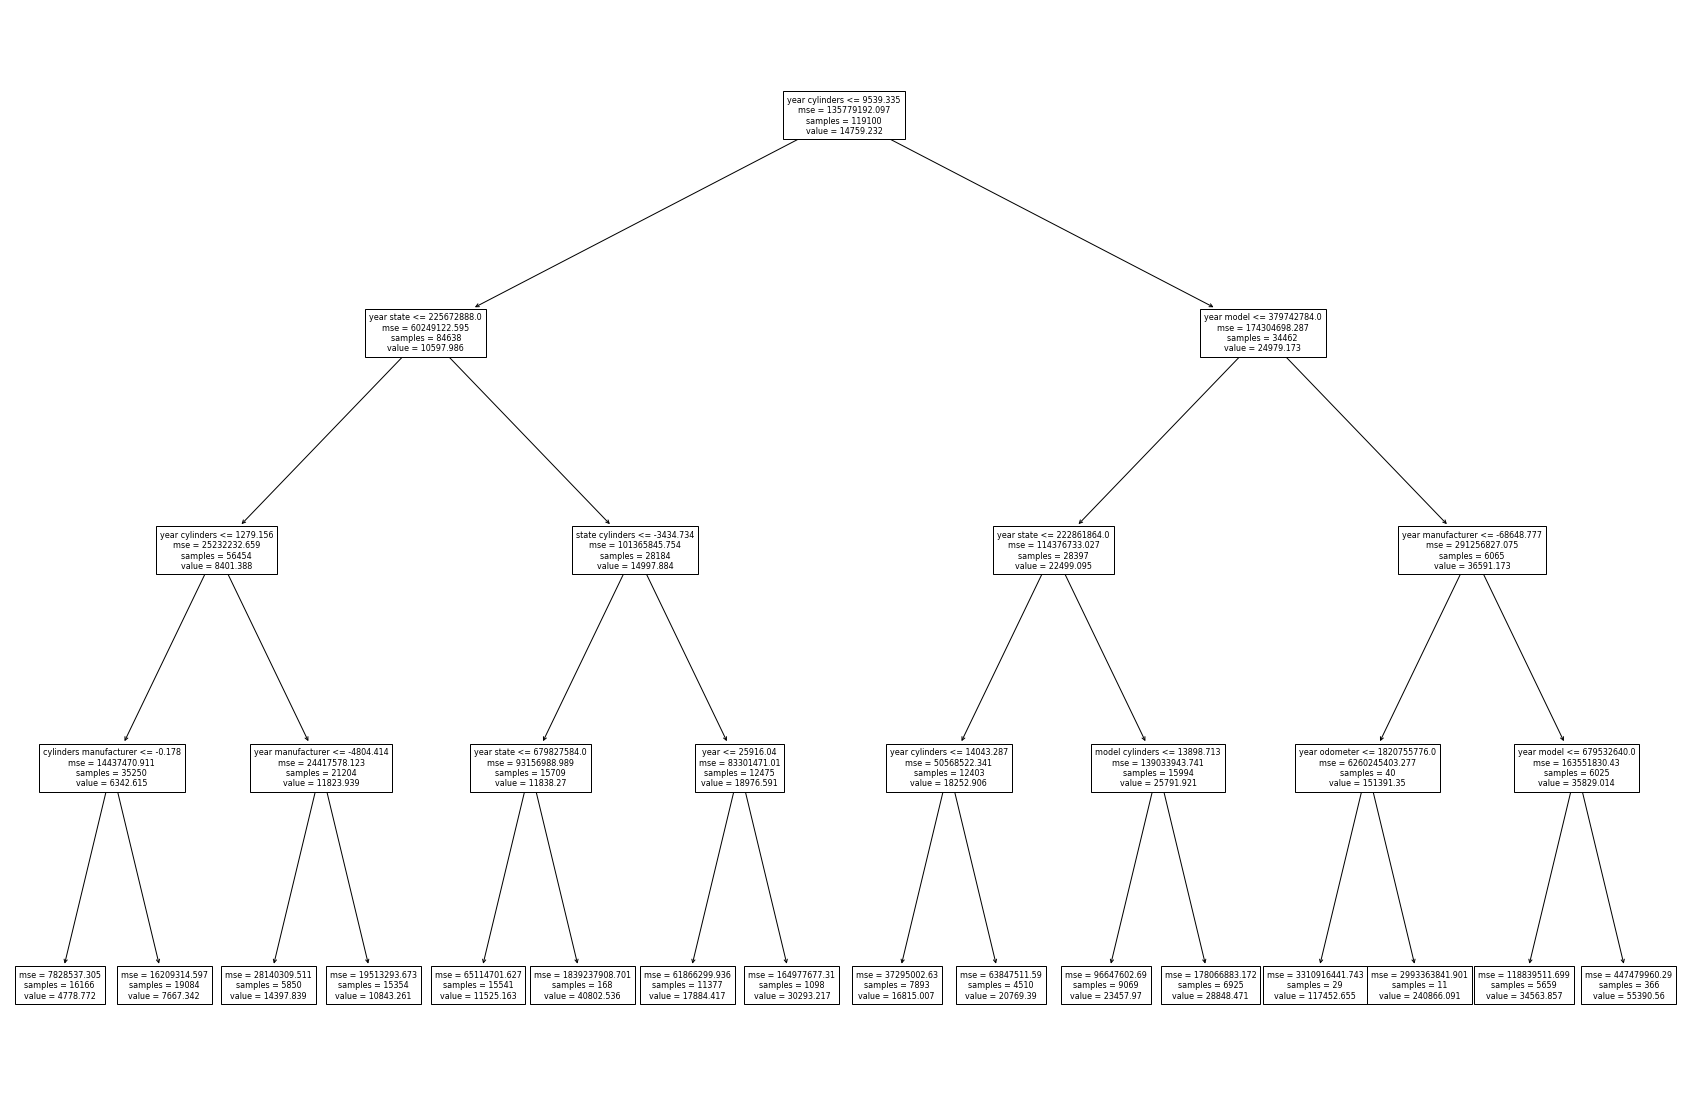

In [0]:
fig, ax = plt.subplots(figsize=(30,20))
plot_tree(model_simple.named_steps["decisiontreeregressor"], fontsize=8, feature_names=model_simple.named_steps['polynomialfeatures'].get_feature_names(X6.columns))
plt.show()

The Decision Tree Regressor has a score of 0.51 while containing at most 20 nodes. The tree plot allows us to interpret the model directly: the first split (for depth=0) is done according to column 'year cylinders', the two following splits (for depth=1) are done according to the 'year state' and 'year model' columns. This already shows that the interaction between the year feature and other categorical features contains much information on the price of the car.

In [0]:
importances = model_simple.named_steps["decisiontreeregressor"].feature_importances_
print(importances)

[0.         0.01638884 0.         0.         0.         0.
 0.         0.01291085 0.12133928 0.14429298 0.58542442 0.06209405
 0.         0.         0.         0.         0.         0.01212773
 0.         0.03765978 0.         0.00776207]


In [0]:
labels = model_simple.named_steps['polynomialfeatures'].get_feature_names(X6.columns)
print(labels)

['1', 'year', 'odometer', 'model', 'state', 'cylinders', 'manufacturer', 'year odometer', 'year model', 'year state', 'year cylinders', 'year manufacturer', 'odometer model', 'odometer state', 'odometer cylinders', 'odometer manufacturer', 'model state', 'model cylinders', 'model manufacturer', 'state cylinders', 'state manufacturer', 'cylinders manufacturer']


In [0]:
importance_tuples = []
for i in range(len(importances)):
  importance_tuples.append((labels[i],importances[i]))
importance_tuples = sorted(importance_tuples, key=lambda x: x[1])
labels_sorted = [x[0] for x in importance_tuples]
importances_sorted = [x[1] for x in importance_tuples]

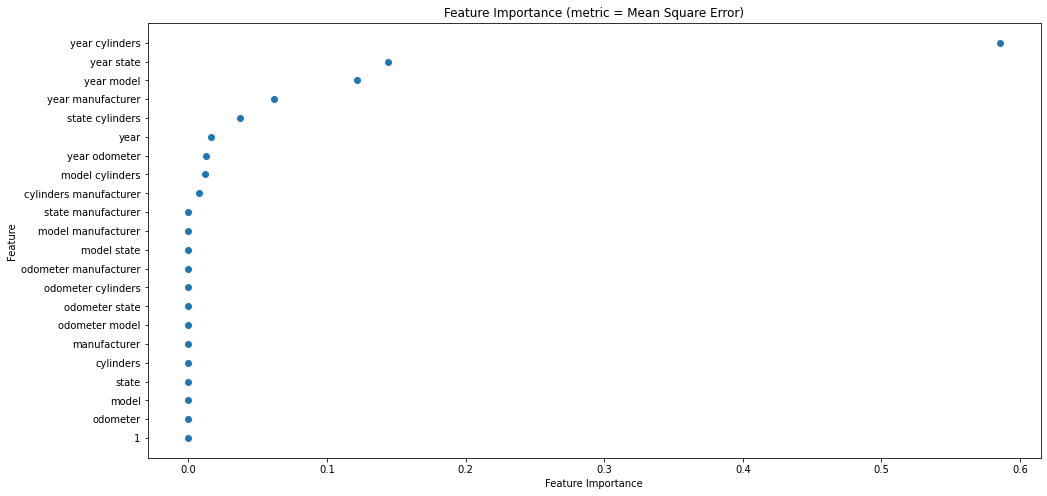

In [0]:
plt.figure(figsize=(16,8))
plt.scatter(importances_sorted,[i for i in range(len(importances))])
plt.yticks([i for i in range(len(importances))], labels_sorted)
plt.title('Feature Importance (metric = Mean Square Error)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

As suggested above, the interaction between 'year' and other features is key in determining the price of the car: six of the seven most important features contain information on year. These features were obtained by applying PolynomialFeatures with degree 2 to the original dataset features.

Intuitively, it makes sense that the interaction of year with other components should be important. The value of a car depreciates strongly over time, and the age of a car affects each model differently. Cars with different types of cylinders, models or manufacturers will lose value differently. 

It is worth noting that this model gives much importance to the interaction features and almost none to the individual features (feature_importance=0 for manufacturer, state, model, odometer). We could explain this by considering that the interaction features already contain most of the information of each feature, meaning splitting according to the individual feature will not add much new information.

Finally, we can note that cylinders, a feature that on its own was not very important in our previous analyses, becomes important to the model once it is put in interaction with other features (year, model and manufacturer).
